In [1]:
import  pandas as pd
import numpy as np
import dask.array as da
import h5py
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import time
import glob
import os

In [2]:
pbar = ProgressBar()
pbar.register()

In [3]:
BASE_DIR = 'D:\VR3D\VR3D_DATASET'

Concatination de tout les chambre dans une seul fichiers 

Pour le cas de Bordeau

In [10]:
Reseau_list = pd.read_csv(path_root,header=None)

In [11]:
for i in range(len(Reseau_list)):
    path_dxf = Reseau_list[0][i]
    os.chdir(path_dxf)
    fichier = open(path_dxf+'\\List_Nuage_filtre.txt','w')
    for file in glob.glob("N*filter*.txt"):
        fichier.write(path_dxf+'\\'+file+'\n')
    fichier.close()

In [12]:
chamb_unit = pd.DataFrame()
for j in range(len(Reseau_list)):
    chambre_file = pd.read_csv(Reseau_list[0][j]+'\\List_Nuage_filtre.txt',header = None)
    for i in range(len(chambre_file)):
        chamb_unit = chamb_unit.append(pd.read_csv(chambre_file[0][i]),ignore_index=True)
chamb_unit.to_csv("D:\VR3D\VR3D_DATASET\Out_final\Bordeau\Total_chambre.txt",index=False)

Pour le cas de paris

In [30]:
chambre_file = pd.read_csv("D:\VR3D\VR3D_DATASET\Out_final\Bordeau\Filtre\Fil_list.txt",header = None)

In [20]:
chamb_unit = pd.DataFrame()
for i in range(len(chambre_file)):
    chamb_unit = chamb_unit.append(pd.read_csv(chambre_file[0][i]),ignore_index=True)
chamb_unit.to_csv("D:\VR3D\VR3D_DATASET\Out_final\Bordeau\Filtre\Total_chambre.txt",index=False)

Pour la visualization ajouter new column RGB/test uniquement

In [4]:
def training_fichier(input_data,i,out_path,daska_data):
    ddf = pd.read_csv(input_data)
    if ddf.shape[0] >= 2:
        #ddf = ddf.rename(columns={0:'X',1:'Y',2:'Z',3:'I'})
        ddf['L'] = 0
        data_labelize = pd.merge(ddf,daska_data,on=['X','Y','Z'])
        data_labelize = data_labelize.drop(columns=['I_y','L_x'])
        data_labelize = data_labelize.rename(columns={'I_x':'I','L_y':'L'})
        data_labelize = pd.concat([ddf,data_labelize],ignore_index=True).drop_duplicates(subset = ['X','Y','Z'],keep = 'last' )
        data_labelize = data_labelize.reset_index(drop = True)
        #data_train = data_labelize[data_labelize.X < 1422376.7884]
        data_labelize.to_csv(out_path.to_numpy()[i][0],index = False) 

In [10]:
def create_input_file(Name):
    _path = BASE_DIR+'\Out_nuage\Down_sample\Down_sample_'+Name+'_0.5'
    os.chdir(_path)
    fichier = open(_path+'\\List_file.txt','w')
    for file in glob.glob('N*.txt'):
        fichier.write(_path+'\\'+file+'\n')
    fichier.close()

In [11]:
def create_output_file(Name):
    in_path = BASE_DIR+'\Out_nuage\Down_sample\Down_sample_'+Name+'_0.5\\List_file.txt'
    out_path = BASE_DIR+'\Out_train\Out_train_'+Name+'_0.5'
    fichier = open(out_path+'\OUT.txt','w')
    for i in range(len(pd.read_csv(in_path,header=None))):
        fichier.write(out_path+'\out'+str(i+1)+'.txt'+'\n')
    fichier.close()

In [15]:
def get_total_chambr(Name):
    for j in range (1): #8:nombre de Zone à travailler 
        _path = BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(j+1)
        x_temp = pd.read_csv(_path+'\\List_file.txt',header=None)
        var_local = pd.DataFrame()
        for i in range(len(x_temp)):
            fichier = pd.read_csv(x_temp[0][i]+'\\List_file_filter.txt',header=None)
            for k in range(len(fichier)):
                ff = pd.read_csv(fichier[0][k])
                var_local = var_local.append(ff,ignore_index=True)
        var_local.to_csv(_path+'\Total_chambre.txt',index = False)
    

In [ ]:
def get_total_chambr(Name):
    for j in range (1): #8:nombre de Zone à travailler 
        _path = BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(j+1)
        x_temp = pd.read_csv(_path+'\\List_file.txt',header=None)
        var_local = pd.DataFrame()
        for i in range(len(x_temp)):
            fichier = pd.read_csv(x_temp[0][i]+'\\List_file_filter.txt',header=None)
            for k in range(len(fichier)):
                ff = pd.read_csv(fichier[0][k])
                var_local = var_local.append(ff,ignore_index=True)
        var_local.to_csv(_path+'\Total_chambre.txt',index = False)

In [13]:
def run(Name):
    get_total_chambr(Name)
    create_input_file(Name)
    create_output_file(Name)
    in_path = pd.read_csv(BASE_DIR+
                          '\Out_nuage\Down_sample\Down_sample_'+Name+'_0.5\List_file.txt',header=None)
    out_path = pd.read_csv(BASE_DIR+'\Out_train\Out_train_'+Name+'_0.5\OUT.txt',header = None)
    for i in range(len(in_path)):
        print(i)
        daska_data = pd.read_csv(BASE_DIR+'\Out_chambre\\'+Name+'\\'+Name+'_Z'+str(1)+'\Total_chambre.txt')
        daska_data = daska_data.rename(columns={'0':'X','1':'Y','2':'Z','3':'I','4':'L'})
        print(i,in_path[0][i])
        training_fichier(in_path[0][i],i,out_path,daska_data)

In [14]:
run('XX')

0


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\VR3D\\VR3D_DATASET\\Out_chambre\\XX\\XX_Z1\\Total_chambre.txt'

Fichier.parquet -----> h5

In [1]:
import h5py
import os
import pandas as pd
import numpy as np
import sys


# Write numpy array data and label to h5_filename
def save_h5(h5_filename, data, label, data_dtype='uint8', label_dtype='uint8'):
    h5_fout = h5py.File(h5_filename,'w')
    h5_fout.create_dataset(
        'data', data=data,
        compression='gzip', compression_opts=4,
        dtype=data_dtype)
    h5_fout.create_dataset(
        'label', data=label,
        compression='gzip', compression_opts=1,
        dtype=label_dtype)
    h5_fout.close()


data_dir ="D:\VR3D\VR3D_DATASET\Out_train\Out_train_Bordeau_0.5"
data_dir = "D:\\MAS\\Pre_traitement\\data_source"
data_dir = "D:\VR3D\VR3D_DATASET\Out_train\Down_sample_bordeau_0.5"
data_dir = "D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite"
data_dir = "D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contour"
# indoor3d_data_dir = os.path.join(data_dir, 'stanford_indoor3d')

# NUM_POINT = 1024
NUM_POINT = 4096
H5_BATCH_SIZE = 1000
data_dim = [NUM_POINT,7]
# data_dim = [NUM_POINT, 7]
label_dim = [NUM_POINT]
data_dtype = 'float32'
label_dtype = 'uint8'

# Set paths
# filelist = os.path.join(data_dir, 'my_data_label.txt')
# = [os.path.join(data_dir, line.rstrip()) for line in open(filelist)]


output_dir = os.path.join(data_dir, 'data\h5_data')

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

output_filename_prefix = os.path.join(output_dir, 'train_VR3D_18_02_2022_H5')
#output_filename_prefix = os.path.join(output_dir, 'test_eclated_from_H5_100')

output_room_filelist = os.path.join(output_dir, 'room_filelist.txt')
fout_room = open(output_room_filelist, 'w')


def room2blocks_randomed_wrapper_normalized(data_label_filename, num_point, block_size=1.0, stride=1.0,
                                            random_sample=False, sample_num=None, sample_aug=1):
    if data_label_filename[-3:] == 'txt':
        #data_label = np.loadtxt(data_label_filename)
        data_label = pd.read_csv(data_label_filename).to_numpy()
    elif data_label_filename[-3:] == 'npy':
        data_label = np.load(data_label_filename)
    elif data_label_filename[-3:] == 'uet':
        data_label = pd.read_parquet(data_label_filename).to_numpy()
    else:
        print('Unknown file type! exiting.')
        exit()
    return room2blocks_randomed_plus_normalized(data_label, num_point, block_size, stride,
                                                random_sample, sample_num, sample_aug)

def room2blocks_randomed_plus_normalized(data_label, num_point, block_size, stride,
                                         random_sample, sample_num, sample_aug):
    """ room2block, with input filename and RGB preprocessing.
        for each block centralize XYZ, add normalized XYZ as 678 channels
    """
    print('\nmise en block...')
    data = data_label[:, 0:4]
    # data[:,3:6] /= 255.0
    label = data_label[:, -1].astype(np.uint8)
    max_room_x = max(data[:, 0])
    max_room_y = max(data[:, 1])
    max_room_z = max(data[:, 2])

    # data_batch, label_batch = room2blocks_random(data_label, num_point)
    data_batch, label_batch = room2blocks_no_random(data_label, num_point)

    new_data_batch = np.zeros((data_batch.shape[0], num_point, 7))
    for b in range(data_batch.shape[0]):
        new_data_batch[b, :, 4] = data_batch[b, :, 0] / max_room_x
        new_data_batch[b, :, 5] = data_batch[b, :, 1] / max_room_y
        new_data_batch[b, :, 6] = data_batch[b, :, 2] / max_room_z
        minx = min(data_batch[b, :, 0])
        miny = min(data_batch[b, :, 1])
        data_batch[b, :, 0] -= (minx + block_size / 2)
        data_batch[b, :, 1] -= (miny + block_size / 2)
    new_data_batch[:, :, 0:4] = data_batch

    return new_data_batch, label_batch


def room2blocks_random(data, num_point):
    # RandomisÃ© data numpy
    np.random.shuffle(data)
    # calculer nombre de blocs de 4096 dans data
    if (data.shape[0] % num_point == 0):
        num_block = data.shape[0] / num_point
    else:
        num_block = data.shape[0] / num_point + 1

    print('num_block = ', num_block)

    # Collect blocks
    block_data_list = []
    block_label_list = []
    idx = 0

    for i in range(int(num_block)):
        # Recuper donnees x,y,z,i
        block_data_sampled = data[int(num_point) * i:int(num_point) * (i + 1), 0:4]

        # Recuper donnees x,y,z,i
        block_label_sampled = data[int(num_point) * i:int(num_point) * (i + 1), -1]

        # print('---------------------------------------------------')
        # print(block_data_sampled)
        # print('---------------------------------------------------')

        # block_label_list.append(np.expand_dims(block_label_sampled, 0))
        if block_data_sampled.shape[0] < num_point:
            sample = np.random.choice(block_data_sampled.shape[0], num_point - block_data_sampled.shape[0])
            dup_data = data[sample, 0:4]
            dup_label = data[sample, -1]
            block_data_sampled = np.concatenate([block_data_sampled, dup_data], 0)
            
            
            
            block_label_sampled = np.concatenate([block_label_sampled, dup_label], 0)
        # print(block_data_sampled.shape[0])
        # print(block_label_sampled.shape[0])

        block_data_list.append(np.expand_dims(block_data_sampled, 0))
        block_label_list.append(np.expand_dims(block_label_sampled, 0))

    return np.concatenate(block_data_list, 0), np.concatenate(block_label_list, 0)


def room2blocks_no_random(data, num_point):
    # calculer nombre de blocs de 4096 dans data
    if (data.shape[0] % num_point == 0):
        num_block = data.shape[0] / num_point
    else:
        num_block = data.shape[0] / num_point + 1

    print('num_block = ',num_block)

    # Collect blocks
    block_data_list = []
    block_label_list = []
    idx = 0

    for i in range(int(num_block)):
        # Recuper donnees x,y,z,i
        block_data_sampled = data[int(num_point) * i:int(num_point) * (i + 1), 0:4]

        # Recuper donnees x,y,z,i
        block_label_sampled = data[int(num_point) * i:int(num_point) * (i + 1), -1]

        # print('---------------------------------------------------')
        # print(block_data_sampled)
        # print('---------------------------------------------------')

        # block_label_list.append(np.expand_dims(block_label_sampled, 0))
        if block_data_sampled.shape[0] < num_point:
            sample = np.random.choice(block_data_sampled.shape[0], num_point - block_data_sampled.shape[0])
            dup_data = data[sample, 0:4]
            dup_label = data[sample, -1]
            block_data_sampled = np.concatenate([block_data_sampled, dup_data], 0)
            block_label_sampled = np.concatenate([block_label_sampled, dup_label], 0)
        # print(block_data_sampled.shape[0])
        # print(block_label_sampled.shape[0])

        block_data_list.append(np.expand_dims(block_data_sampled, 0))
        block_label_list.append(np.expand_dims(block_label_sampled, 0))

    return np.concatenate(block_data_list, 0), np.concatenate(block_label_list, 0)



# --------------------------------------
# ----- BATCH WRITE TO HDF5 -----
# --------------------------------------
batch_data_dim = [H5_BATCH_SIZE] + data_dim
batch_label_dim = [H5_BATCH_SIZE] + label_dim
h5_batch_data = np.zeros(batch_data_dim, dtype=np.float32)
h5_batch_label = np.zeros(batch_label_dim, dtype=np.uint8)
buffer_size = 0  # state: record how many samples are currently in buffer
h5_index = 0  # state: the next h5 file to save


def insert_batch(data, label, last_batch=False):
    global h5_batch_data, h5_batch_label
    global buffer_size, h5_index
    data_size = data.shape[0]
    print("\ninsert_batch...")

    # If there is enough space, just insert
    if buffer_size + data_size <= h5_batch_data.shape[0]:
        print('if :', buffer_size + data_size, ' <= ', h5_batch_data.shape[0])
        print("there is space... insert new batch")
        h5_batch_data[buffer_size:buffer_size + data_size, ...] = data
        h5_batch_label[buffer_size:buffer_size + data_size] = label
        buffer_size += data_size
    else:  # not enough space
        print('if :', buffer_size + data_size, ' > ', h5_batch_data.shape[0])
        print("Space is not enough... ")
        capacity = h5_batch_data.shape[0] - buffer_size
        assert (capacity >= 0)
        if capacity > 0:
            h5_batch_data[buffer_size:buffer_size + capacity, ...] = data[0:capacity, ...]
            h5_batch_label[buffer_size:buffer_size + capacity, ...] = label[0:capacity, ...]
            # Save batch data and label to h5 file, reset buffer_size
        h5_filename = output_filename_prefix + '_' + str(h5_index) + '.h5'
        save_h5(h5_filename, h5_batch_data, h5_batch_label, data_dtype, label_dtype)
        print('Stored {0} with size {1}'.format(h5_filename, h5_batch_data.shape[0]))
        h5_index += 1
        buffer_size = 0
        # recursive call
        insert_batch(data[capacity:, ...], label[capacity:, ...], last_batch)
    if last_batch and buffer_size > 0:
        print('if : last_batch = True et buffer_size = ', buffer_size, 'est >0')

        h5_filename = output_filename_prefix + '_' + str(h5_index) + '.h5'
        save_h5(h5_filename, h5_batch_data[0:buffer_size, ...], h5_batch_label[0:buffer_size, ...],
                               data_dtype, label_dtype)
        print('Stored {0} with size {1}'.format(h5_filename, buffer_size))
        h5_index += 1
        buffer_size = 0

    print('\nFINISHED.\nNext h5_index for filename output = ', h5_index, '\n')
    return


output_room_filelist = os.path.join(output_dir, 'room_filelist.txt')
fout_room = open(output_room_filelist, 'w')

#file_name = ['PNC1.txt', 'PNC2.txt', 'PNC3.txt', 'PNC4.txt', 'PNC5.txt']
#file_name = ['PNC5_cal_100.txt']
#file_name = ['p2_zone1.txt','p2_zone3.txt','p2_zone4.txt','p3_zone1.txt','p4_zone1.txt','p4_zone2.txt','p4_zone3.txt']
file_list = pd.read_csv("D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\OUT_rect.txt",header = None)
file_name = [file[0] for file in file_list.to_numpy()]
#filename = ["D:\\MAS\\Pre_traitement\\data_source\\p1_zone1.txt"]
sample_cnt = 0
for i, data_label_filename in enumerate(file_name):

    print('\n', data_dir + data_label_filename, '...')

    #block_size = 200000.0
    #stride = 100000.0
    data, label = room2blocks_randomed_wrapper_normalized(data_label_filename, NUM_POINT, block_size=1.0,
                                                 stride=0.5,
                                                 random_sample=False, sample_num=None)
    print('\n Sortie Data shape = {0}, Label shape = {1}'.format(data.shape, label.shape))
    for _ in range(data.shape[0]):
        fout_room.write(os.path.basename(data_label_filename) + '\n')

    sample_cnt += data.shape[0]

    print('IS i=', i, ' === ', 'len(file_name)-1=', len(file_name) - 1)
    insert_batch(data, label, i == len(file_name) - 1)

fout_room.close()
print("Total samples: {0}".format(sample_cnt))




 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb0.txt ...

mise en block...
num_block =  4.418212890625

 Sortie Data shape = (4, 4096, 7), Label shape = (4, 4096)
IS i= 0  ===  len(file_name)-1= 66

insert_batch...
if : 4  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb1_visu_rect1.txt ...

mise en block...
num_block =  3.789794921875

 Sortie Data shape = (3, 4096, 7), Label shape = (3, 4096)
IS i= 1  ===  len(file_name)-1= 66

insert_batch...
if : 7  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb2.txt ...

mise en block...
num_block =  6.49609375

 Sortie Data shape = (6

num_block =  32.475341796875

 Sortie Data shape = (32, 4096, 7), Label shape = (32, 4096)
IS i= 22  ===  len(file_name)-1= 66

insert_batch...
if : 230  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb23.txt ...

mise en block...
num_block =  10.701416015625

 Sortie Data shape = (10, 4096, 7), Label shape = (10, 4096)
IS i= 23  ===  len(file_name)-1= 66

insert_batch...
if : 240  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb24.txt ...

mise en block...
num_block =  6.323486328125

 Sortie Data shape = (6, 4096, 7), Label shape = (6, 4096)
IS i= 24  ===  len(file_name)-1= 66

insert_batch...
if : 246  <=  1000
there is space... insert new batch




mise en block...
num_block =  6.25634765625

 Sortie Data shape = (6, 4096, 7), Label shape = (6, 4096)
IS i= 47  ===  len(file_name)-1= 66

insert_batch...
if : 424  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb48_visu_rect1.txt ...

mise en block...
num_block =  7.001708984375

 Sortie Data shape = (7, 4096, 7), Label shape = (7, 4096)
IS i= 48  ===  len(file_name)-1= 66

insert_batch...
if : 431  <=  1000
there is space... insert new batch

FINISHED.
Next h5_index for filename output =  0 


 D:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\Filtre_contourD:\VR3D\VR3D_DATASET\Out_nuage\Filtre_intensite\chambre_rgb49.txt ...

mise en block...
num_block =  9.31005859375

 Sortie Data shape = (9, 4096, 7), Label shape = (9, 4096)
IS i= 49  ===  len(file_name)-1= 66

insert_batch...
if : 440  <=  1000
there is space.

Check if your data.h5 result.shape is == 1000
S'il existe reshape le,par defaut c'est le dernier  fichier qui est de shape inferieur a 1000

In [5]:
import h5py

In [173]:
path_input = "D:\\MAS\\Pre_traitement\\data_source\\data\\h5_data\\train_MAS13_01_2022_H5_0.h5"

In [174]:
file_input = h5py.File(path_input,'r')

In [178]:
path_outp = "D:\VR3D\VR3D_DATASET\Out_train\Out_train_Bordeau_0.5\data\h5_data\\ttzMAS_final.h5"

In [179]:
file_outp = h5py.File(path_outp,'w')

In [180]:
dset_app = file_outp.create_dataset('data',shape = (1000,4096,7))
label_app = file_outp.create_dataset('label',shape = (1000,4096))

In [181]:
file_input['data']

<HDF5 dataset "data": shape (945, 4096, 7), type "<f4">

In [168]:
file_input.close()

In [90]:
def save_h5(h5_filename, data, label, data_dtype='uint8', label_dtype='uint8'):
    h5_fout = h5py.File(h5_filename,'w')
    h5_fout.create_dataset(
        'data', data=data,)
    h5_fout.create_dataset(
        'label', data=label,
        compression='gzip')
    h5_fout.close()

In [99]:
path_input = "D:\\VR3D\\VR3D_DATASET\\Out_train\\vr3d_Baumann\\archive\\data\\h5_data\\train_29_10_2021_H5_0.h5"
path_output = "D:\\VR3D\\VR3D_DATASET\\Out_train\\vr3d_Baumann\\archive\\data\\h5_data\\train_testBA_06_12_2021_H5_0.h5"
file_input = h5py.File(path_input,'r')
data = np.array(file_input['data'][:,:,-3:])
data = data.reshape((-1,2048,3))
label = np.array(file_input['label'][:])
label = label.reshape((-1,2048))
#print(file_input['data'][:,:,-3:])
save_h5(path_output,data,label,data_dtype='uint8', label_dtype='uint8') 
file_input.close

<bound method File.close of <HDF5 file "train_29_10_2021_H5_0.h5" (mode r)>>

In [9]:
path = "D:\\VR3D\\VR3D_DATASET\\Out_train\\Out_train_Bordeau_0.5\\data\\h5_data\\train_13_01_2022_H5_0.h5"

In [10]:
file = h5py.File(path,'r')

In [26]:
file['data'][999,:,3]


array([2244., 2245., 2270., ..., 2269., 2280., 2276.], dtype=float32)

In [15]:
len(file['data'][5, :, 0])

4096

In [19]:
len(file['data'][:, :, 0:4])

1000

In [27]:
2+2/2


3.0

In [1]:
import numpy as np
import h5py

In [4]:
path = "D:\VR3D\code\ML-VR3D\code\ML-VR3D\Pretraitement\data\\h5_data\\train_VR3D_Zpts_04_2022_H5_2.h5"

In [5]:
file = h5py.File(path,'r')

In [10]:
path_outp = "D:\VR3D\code\ML-VR3D\code\ML-VR3D\Pretraitement\data\\h5_data\\train_VR3Dpts.h5"

In [11]:
file_outp = h5py.File(path_outp,'w')

In [12]:
file_outp.create_dataset(
    'data',shape= (1000,4096,7),
    compression='gzip')
#file_outp['data'][:] = file['data'][:]
file_outp.create_dataset(
    'label',shape=(1000,4096),
    compression='gzip')
#file_outp['label'][:] = file['label'][:]

<HDF5 dataset "label": shape (1000, 4096), type "<f4">

In [13]:
file_outp['data']

<HDF5 dataset "data": shape (1000, 4096, 7), type "<f4">

In [14]:
shp = file['data'].shape[0]

In [15]:
shp

754

In [16]:
file['data'][:1]

array([[[ 1.209     ,  0.974     , 58.982     , ...,  0.99994373,
          0.9999685 ,  0.67053956],
        [ 1.21      ,  0.396     , 58.988     , ...,  0.99994373,
          0.99996835,  0.67060775],
        [ 1.192     ,  0.202     , 58.98      , ...,  0.99994373,
          0.9999683 ,  0.6705168 ],
        ...,
        [ 0.201     , -0.268     , 59.029     , ...,  0.999943  ,
          0.99996823,  0.67107385],
        [-0.198     , -0.32      , 59.054     , ...,  0.9999428 ,
          0.9999682 ,  0.6713581 ],
        [ 0.759     , -0.39      , 59.024     , ...,  0.99994344,
          0.9999682 ,  0.67101705]]], dtype=float32)

In [17]:
file_outp['data'][:shp] = file['data'][:shp]
file_outp['label'][:shp] = file['label'][:shp]
boolean = True
i = 1
while boolean:
    if shp*(i+1)<1000:
        print(i)
        file_outp['data'][shp*i:shp*(i+1)] = file['data'][:shp]
        file_outp['label'][shp*i:shp*(i+1)] = file['label'][:shp]
        i +=1
    else :
        file_outp['data'][shp*i:] = file['data'][:1000-shp*i]
        file_outp['label'][shp*i:] = file['label'][:1000-shp*i]
        boolean = False

In [18]:
file['data'][:]

array([[[ 1.2090000e+00,  9.7399998e-01,  5.8981998e+01, ...,
          9.9994373e-01,  9.9996853e-01,  6.7053956e-01],
        [ 1.2100000e+00,  3.9600000e-01,  5.8987999e+01, ...,
          9.9994373e-01,  9.9996835e-01,  6.7060775e-01],
        [ 1.1920000e+00,  2.0200001e-01,  5.8980000e+01, ...,
          9.9994373e-01,  9.9996829e-01,  6.7051679e-01],
        ...,
        [ 2.0100001e-01, -2.6800001e-01,  5.9028999e+01, ...,
          9.9994302e-01,  9.9996823e-01,  6.7107385e-01],
        [-1.9800000e-01, -3.1999999e-01,  5.9054001e+01, ...,
          9.9994278e-01,  9.9996817e-01,  6.7135811e-01],
        [ 7.5900000e-01, -3.8999999e-01,  5.9023998e+01, ...,
          9.9994344e-01,  9.9996817e-01,  6.7101705e-01]],

       [[ 6.8999998e-02, -2.0500000e-01,  5.9015999e+01, ...,
          9.9994296e-01,  9.9996823e-01,  6.7092609e-01],
        [ 7.5900000e-01, -4.4900000e-01,  5.9037998e+01, ...,
          9.9994344e-01,  9.9996817e-01,  6.7117620e-01],
        [ 7.3000002e-01, 

In [19]:
file_outp['data'][:]

array([[[ 1.2090000e+00,  9.7399998e-01,  5.8981998e+01, ...,
          9.9994373e-01,  9.9996853e-01,  6.7053956e-01],
        [ 1.2100000e+00,  3.9600000e-01,  5.8987999e+01, ...,
          9.9994373e-01,  9.9996835e-01,  6.7060775e-01],
        [ 1.1920000e+00,  2.0200001e-01,  5.8980000e+01, ...,
          9.9994373e-01,  9.9996829e-01,  6.7051679e-01],
        ...,
        [ 2.0100001e-01, -2.6800001e-01,  5.9028999e+01, ...,
          9.9994302e-01,  9.9996823e-01,  6.7107385e-01],
        [-1.9800000e-01, -3.1999999e-01,  5.9054001e+01, ...,
          9.9994278e-01,  9.9996817e-01,  6.7135811e-01],
        [ 7.5900000e-01, -3.8999999e-01,  5.9023998e+01, ...,
          9.9994344e-01,  9.9996817e-01,  6.7101705e-01]],

       [[ 6.8999998e-02, -2.0500000e-01,  5.9015999e+01, ...,
          9.9994296e-01,  9.9996823e-01,  6.7092609e-01],
        [ 7.5900000e-01, -4.4900000e-01,  5.9037998e+01, ...,
          9.9994344e-01,  9.9996817e-01,  6.7117620e-01],
        [ 7.3000002e-01, 

In [20]:
file_outp['data']

<HDF5 dataset "data": shape (1000, 4096, 7), type "<f4">

In [21]:
file_outp.close()
file.close()

Equilibrage Intensite (donne d'entrainement)

In [372]:
path_mas = "D:\\MAS\\Pre_traitement\\data\\h5_data\\ply_data_all_3.h5"

In [388]:
a = file_outp['data'][:]

In [381]:
b = file['data'][:,:,3]

In [354]:
a = a.flatten()

In [355]:
df = pd.DataFrame(a)

In [391]:
file.close()
file_outp.close()

In [356]:
a = df[(df[0] <= 2300.0)]


In [357]:
a = a.reset_index(drop=True)

In [358]:
a[0].values

array([2205., 2182., 2189., ..., 2213., 2225., 2228.], dtype=float32)

In [245]:
a*141 - 275930

array([34975., 31732., 32719., ..., 36103., 37795., 38218.])

In [91]:
len(df[(df[0] <= 2300.0)&(df[0] >= 2050.0)])/len(df)

0.996503173828125

In [227]:
a = df[(df[0] <= 2300.0)&(df[0] >= 2050.0)]

In [235]:
np.array(a[0]).reshape((-1,4096))

ValueError: cannot reshape array of size 4081677 into shape (4096)

In [77]:
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt

In [ ]:
(inten_Mas + 275930)/141

In [150]:
(13120.0 + 275930)/141

2050.0

In [152]:
2050*141 - 275930

13120

In [ ]:
min = 2050
max = 2300
MAS.min() = 13120.0
MAS.max() = 48377.0

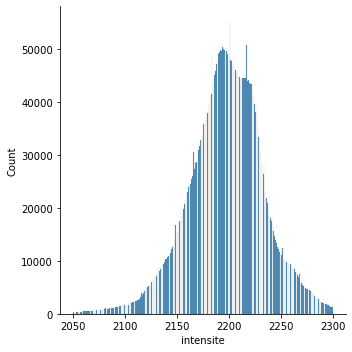

In [94]:
sns.displot(a,x=a[0])
plt.xlabel('intensite')
plt.show()

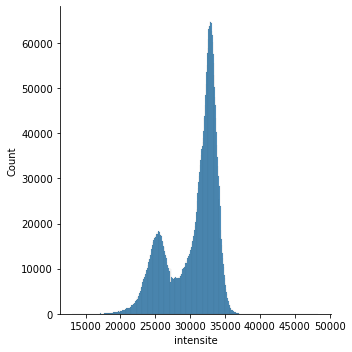

In [78]:
sns.displot(df,x=df[0])
plt.xlabel('intensite')
plt.show()

In [16]:
file_outp['data'][:,:,3]

array([[21690., 22680., 21950., ..., 22000., 22130., 21500.],
       [21830., 22070., 22060., ..., 21930., 21560., 22010.],
       [22080., 21970., 22070., ..., 22330., 21980., 22080.],
       ...,
       [21490., 21200., 22060., ..., 22030., 21620., 21590.],
       [21500., 21890., 21140., ..., 21700., 21960., 21670.],
       [21680., 21370., 21440., ..., 21510., 21890., 21800.]],
      dtype=float32)

In [17]:
file_outp.close()
file.close()

In [72]:
MAS.min() = 13120.0
MAS.max() = 48377.0
VR3D.min() = 256
VR3D.max() = 65408.0

Equilibrage intensite (Test)

In [1]:
import laspy

In [2]:
from laspy.file import File
import numpy as np

In [4]:
path = "C:\\Users\\a.rakotoarisoa\\PycharmProjects\\ML-VR3D\\VR3D\\labelisation_automatique\\Test\\test\\Annotations\\history\\out1_test.las"

In [5]:
path_outp = "C:\\Users\\a.rakotoarisoa\\PycharmProjects\\ML-VR3D\\VR3D\\labelisation_automatique\\Test\\test\\Annotations\\history\\modife_out1_test.txt"

In [6]:
file = File(path,mode='rw')

In [7]:
file

In [36]:
binary_classes = np.empty((len(file.x), 4))

binary_classes[:, 0] = file.x
binary_classes[:, 1] = file.y
binary_classes[:, 2] = file.z
binary_classes[:, 3] = file.intensity

In [37]:
binary_classes[:, 3] = binary_classes[:,3]*10

In [38]:
binary_classes[:, 3] 

array([ 42020.,  38070.,  34200., ..., 115030.,  47820.,  76470.])

In [39]:
binary_classes

array([[1.49528562e+06, 7.19699633e+06, 5.39000000e+01, 4.20200000e+04],
       [1.49528569e+06, 7.19699626e+06, 5.39100000e+01, 3.80700000e+04],
       [1.49528572e+06, 7.19699623e+06, 5.39100000e+01, 3.42000000e+04],
       ...,
       [1.49528578e+06, 7.19700052e+06, 5.37800000e+01, 1.15030000e+05],
       [1.49528577e+06, 7.19700049e+06, 5.38600000e+01, 4.78200000e+04],
       [1.49528576e+06, 7.19700049e+06, 5.38600000e+01, 7.64700000e+04]])

In [40]:
np.savetxt(path_outp,binary_classes,delimiter=",")

In [41]:
import os

In [254]:
save_path ="C:\\Users\\a.rakotoarisoa\\PycharmProjects\\ML-VR3D\\VR3D\\labelisation_automatique\\Test\\test\\Annotations\\history\\data_contour_1.txt"

In [42]:
os.system('D:\VR3D\Tools\LAStools\\bin\\txt2las.exe -i \"' + path_outp+ '\" -parse xyzi -olas')

0

In [43]:
file.close()

In [6]:
import dask.dataframe as dd
import dask
import time

In [ ]:
t1 = time.time()
path = "D:\VR3D\VR3D_DATASET\First_vr3d_PTS.txt"
ddf = dd.read_csv(path, header = None, sep = ' ')
print(dask.compute(*ddf[0]))
t2 = time.time()
print('time execution in ', t2-t1)
print('process finish !')